# Machine Translation + Transformer ( ENGLISH -> KHMMER)

<img src = "./figures/transformer1.png" >

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random, math, time, re
from collections import Counter
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


c:\Users\svrat\Documents\2026-Jan\NLP\NLP-Assignment-2026\A3_Make_Your_Own_Machine_Translation_Language\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
# torch.cuda.get_device_name(0)

'Tesla T4'

In [2]:
import sys
print(sys.version)

3.11.13 (main, Aug 18 2025, 19:14:35) [MSC v.1944 64 bit (AMD64)]


In [3]:
torch.__version__

'2.2.0+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to Khmer since it is my native language. The datasets is quite limited and hard to find but let's get through it. 

In [ ]:
from huggingface_hub import login
login(token=" ")

In [5]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset(
    "liboaccn/nmt-parallel-corpus",
    "en-km",
    split="train"
)

ds = ds.select(range(20000))


In [7]:
ds.save_to_disk("./en_km_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/20000 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 20000/20000 [00:00<00:00, 446041.22 examples/s]


In [8]:
# from datasets import load_from_disk

# ds = load_from_disk("en_km_datase.zip")

In [9]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'km'


In [10]:
ds

Dataset({
    features: ['src_txt', 'tgt_txt', 'src_lang', 'tgt_lang', 'dataset'],
    num_rows: 20000
})

In [11]:
train_size = len(ds)
train_size

20000

In [12]:
# Split the original dataset into 80% train and 20% (temp) test+validation
train_test_valid = ds.train_test_split(test_size=0.2, seed=42)

# Split the 20% (temp) test+validation data into half (10% test, 10% validation of original data)
test_valid = train_test_valid['test'].train_test_split(test_size=0.5, seed=42)

In [13]:
from datasets import DatasetDict

final_ds = DatasetDict({
    'train': train_test_valid['train'],
    'validation': test_valid['train'], # this is the validation set
    'test': test_valid['test']         # this is the test set
})
print(final_ds)

DatasetDict({
    train: Dataset({
        features: ['src_txt', 'tgt_txt', 'src_lang', 'tgt_lang', 'dataset'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['src_txt', 'tgt_txt', 'src_lang', 'tgt_lang', 'dataset'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['src_txt', 'tgt_txt', 'src_lang', 'tgt_lang', 'dataset'],
        num_rows: 2000
    })
})


In [14]:
train = final_ds['train']
validation = final_ds['validation']
test = final_ds['test']

print(f"Number of training examples: {len(train)}")
print(f"Number of validation examples: {len(validation)}")
print(f"Number of testing examples: {len(test)}")

Number of training examples: 16000
Number of validation examples: 2000
Number of testing examples: 2000


In [15]:
sample = final_ds["train"][0]
sample

{'src_txt': 'Every man, therefore, that hath heard, and hath learned of the Father, cometh unto me."',
 'tgt_txt': '" អស់ អ្នក  ដែល បាន ស្ដាប់  ព្រះបិតា, ហើយ  ទទួល យក  ការ ប្រៀន ប្រដៅ  របស់ ព្រះអង្គ, មុខ ជា  មក រក ខ្ញុំ  ពុំខាន។',
 'src_lang': 'en',
 'tgt_lang': 'km',
 'dataset': 'NLLB-v1-en-km'}

# 3. Preprocessing

In [16]:
token_transform = {}
vocab_transform = {}

In [17]:
import spacy
from khmernltk import  word_tokenize

spacy_en = spacy.blank("en")

token_transform[SRC_LANGUAGE] = lambda txt: [tok.text for tok in spacy_en(txt)]
token_transform[TRG_LANGUAGE] = lambda txt:  word_tokenize(txt)

In [18]:
#example of tokenization of the english part
print("Sentence:", sample["src_txt"])
print("Tokenization:", token_transform[SRC_LANGUAGE](sample["src_txt"]))

Sentence: Every man, therefore, that hath heard, and hath learned of the Father, cometh unto me."
Tokenization: ['Every', 'man', ',', 'therefore', ',', 'that', 'hath', 'heard', ',', 'and', 'hath', 'learned', 'of', 'the', 'Father', ',', 'cometh', 'unto', 'me', '.', '"']


In [19]:
#example of tokenization of the Khmer part
print("Sentence:", sample["tgt_txt"])
print("Tokenization:", token_transform[TRG_LANGUAGE](sample["tgt_txt"]))

Sentence: " អស់ អ្នក  ដែល បាន ស្ដាប់  ព្រះបិតា, ហើយ  ទទួល យក  ការ ប្រៀន ប្រដៅ  របស់ ព្រះអង្គ, មុខ ជា  មក រក ខ្ញុំ  ពុំខាន។


| 2026-02-09 22:20:05,660 | INFO | khmer-nltk | Loaded model from c:\Users\svrat\Documents\2026-Jan\NLP\NLP-Assignment-2026\A3_Make_Your_Own_Machine_Translation_Language\.venv\Lib\site-packages\khmernltk\word_tokenize\sklearn_crf_ner_10000.sav |


Tokenization: ['"', ' ', 'អស់', ' ', 'អ្នក', ' ', 'ដែល', ' ', 'បាន', ' ', 'ស្ដាប់', ' ', 'ព្រះបិតា', ',', ' ', 'ហើយ', ' ', 'ទទួល', ' ', 'យក', ' ', 'ការ', ' ', 'ប្រៀន', ' ', 'ប្រដៅ', ' ', 'របស់', ' ', 'ព្រះអង្គ', ',', ' ', 'មុខ', ' ', 'ជា', ' ', 'មក', ' ', 'រក', ' ', 'ខ្ញុំ', ' ', 'ពុំ', 'ខាន', '។']


In [20]:
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 'src_txt', TRG_LANGUAGE: 'tgt_txt'}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]])

In [21]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [22]:
from collections import Counter
from typing import Iterable, List, Dict, Callable, Optional

In [23]:
class SimpleVocab:
    def __init__(self, itos: List[str], default_index: int = 0):
        self.itos = itos
        self.stoi = {tok: i for i, tok in enumerate(itos)}
        self.default_index = default_index

    def __len__(self):
        return len(self.itos)

    def set_default_index(self, idx: int):
        self.default_index = idx
        
    def __call__(self, tokens):
        return [self[t] for t in tokens]


    def get_itos(self):
        return self.itos
    
    def __getitem__(self, token: str) -> int:
        # token -> id
        return self.stoi.get(token, self.default_index)

    def lookup_tokens(self, ids: List[int]) -> List[str]:
        return [self.itos[i] for i in ids]

    def lookup_indices(self, tokens: List[str]) -> List[int]:
        return [self[t] for t in tokens]


In [24]:
def build_vocab_from_iterator(
    iterator: Iterable[List[str]],
    min_freq: int = 1,
    specials: Optional[List[str]] = None,
    special_first: bool = True,
    max_tokens: Optional[int] = None,
) -> SimpleVocab:
    counter = Counter()
    for tokens in iterator:
        counter.update(tokens)

    specials = specials or []
    specials_set = set(specials)

    # sort by frequency desc, then token asc (stable/reproducible)
    sorted_tokens = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    vocab_tokens = []
    for tok, freq in sorted_tokens:
        if freq < min_freq:
            break
        if tok in specials_set:
            continue
        vocab_tokens.append(tok)
        if max_tokens is not None and len(vocab_tokens) >= max_tokens:
            break

    itos = (specials + vocab_tokens) if special_first else (vocab_tokens + specials)
    vocab = SimpleVocab(itos=itos, default_index=0)  # default to UNK initially
    return vocab


In [25]:
vocab_transform = {}

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train, ln),
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)


In [26]:
#see some example
vocab_transform[SRC_LANGUAGE].lookup_indices(
    ['here', 'is', 'a', 'unknownword', 'a']
)


[193, 12, 13, 0, 13]

In [27]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'passed'

In [28]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [29]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [30]:
#check unique vocabularies
len(mapping)

11721

# 4. Preparing the dataloader

In [31]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 16 
MAX_LEN = 512

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
# def tensor_transform(token_ids):
#     return torch.cat((torch.tensor([SOS_IDX]), 
#                       torch.tensor(token_ids), 
#                       torch.tensor([EOS_IDX])))

def tensor_transform(token_ids):
    token_ids = token_ids[:MAX_LEN - 2]  # leave space for SOS and EOS
    return torch.cat((
        torch.tensor([SOS_IDX]),
        torch.tensor(token_ids),
        torch.tensor([EOS_IDX])
    ))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []

    for item in batch:
        src_sample = item["src_txt"]
        trg_sample = item["tgt_txt"]

        processed_src = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        processed_trg = text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n"))

        src_batch.append(processed_src)
        trg_batch.append(processed_trg)
        src_len_batch.append(processed_src.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)

    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch


In [32]:
batch_size = 16 

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(validation,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [33]:
for en, en_len, km in train_loader:
    break

print("English shape:", en.shape)   # (batch, seq_len) because batch_first=True
print("English lengths:", en_len.shape)
print("Target shape:", km.shape)    # (batch, seq_len)


English shape: torch.Size([16, 45])
English lengths: torch.Size([16])
Target shape: torch.Size([16, 50])


In [40]:
en, _, km = next(iter(train_loader))
print("src batch shape:", en.shape)  # (batch, src_len)
print("tgt batch shape:", km.shape)  # (batch, tgt_len)
print("max src_len:", en.shape[1])
print("max tgt_len:", km.shape[1])


src batch shape: torch.Size([16, 42])
tgt batch shape: torch.Size([16, 76])
max src_len: 42
max tgt_len: 76


In [34]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

In [35]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 512):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        if src_len > self.pos_embedding.num_embeddings:
            raise ValueError(f"ENC pos_embedding too small: src_len={src_len}, max_len={self.pos_embedding.num_embeddings}")

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src

In [54]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        # self.fc_q     = nn.Linear(hid_dim, hid_dim)
        # self.fc_k     = nn.Linear(hid_dim, hid_dim)
        # self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        # Q = self.fc_q(query)
        # K = self.fc_k(key)
        # V = self.fc_v(value)
        
        Q, K, V = query, key, value
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

In [55]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [56]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

In [57]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device,max_length = 512):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        if trg_len > self.pos_embedding.num_embeddings:
            raise ValueError(f"DEC pos_embedding too small: trg_len={trg_len}, max_len={self.pos_embedding.num_embeddings}")

        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

In [58]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [59]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [60]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
CUDA_LAUNCH_BLOCKING=1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [61]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device)

dec = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(11721, 256)
    (pos_embedding): Embedding(512, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (tok_embedding): Embedding(10311, 256)
    (pos_embedding): Embedding(512, 25

In [62]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

3000576
131072
   256
   256
   256
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
131072
   512
131072
   256
2639616
131072
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
2639616
 10311
______
10729543


In [63]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [64]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [65]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [66]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [67]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [69]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 18m 4s
	Train Loss: 3.624 | Train PPL:  37.499
	 Val. Loss: 3.616 |  Val. PPL:  37.170
Epoch: 02 | Time: 17m 20s
	Train Loss: 3.494 | Train PPL:  32.934
	 Val. Loss: 3.560 |  Val. PPL:  35.157
Epoch: 03 | Time: 17m 45s
	Train Loss: 3.384 | Train PPL:  29.499
	 Val. Loss: 3.534 |  Val. PPL:  34.250
Epoch: 04 | Time: 17m 28s
	Train Loss: 3.285 | Train PPL:  26.717
	 Val. Loss: 3.497 |  Val. PPL:  33.018
Epoch: 05 | Time: 17m 31s
	Train Loss: 3.191 | Train PPL:  24.318
	 Val. Loss: 3.470 |  Val. PPL:  32.132
Epoch: 06 | Time: 17m 20s
	Train Loss: 3.103 | Train PPL:  22.257
	 Val. Loss: 3.468 |  Val. PPL:  32.076
Epoch: 07 | Time: 17m 25s
	Train Loss: 3.017 | Train PPL:  20.420
	 Val. Loss: 3.451 |  Val. PPL:  31.528
Epoch: 08 | Time: 17m 21s
	Train Loss: 2.933 | Train PPL:  18.789
	 Val. Loss: 3.448 |  Val. PPL:  31.449
Epoch: 09 | Time: 17m 11s
	Train Loss: 2.859 | Train PPL:  17.448
	 Val. Loss: 3.466 |  Val. PPL:  32.008
Epoch: 10 | Time: 17m 12s
	Train Loss: 2.786 | 

Text(0, 0.5, 'loss')

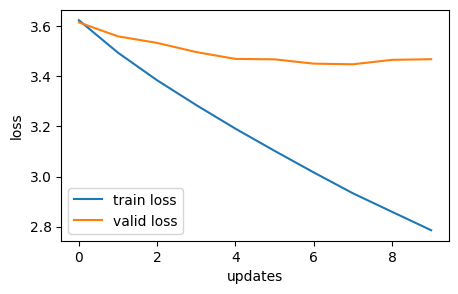

In [70]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [71]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.452 | Test PPL:  31.568 |


In [72]:
sample["src_txt"]

'Every man, therefore, that hath heard, and hath learned of the Father, cometh unto me."'

In [74]:
src_text = text_transform[SRC_LANGUAGE](sample["tgt_txt"]).to(device)
src_text

tensor([   2,   10,    0,    0, 2182,    0,    0,    0, 2182,    0,    5,    0,
        2182,    0,    0, 2182,    0,    0,    0, 2182,    0,    0,    5,    0,
           0, 2182,    0,    0,    0, 2182,    0,    3])

In [75]:
sample["tgt_txt"]

'" អស់ អ្នក  ដែល បាន ស្ដាប់  ព្រះបិតា, ហើយ  ទទួល យក  ការ ប្រៀន ប្រដៅ  របស់ ព្រះអង្គ, មុខ ជា  មក រក ខ្ញុំ  ពុំខាន។'

In [76]:
trg_text = text_transform[TRG_LANGUAGE](sample["tgt_txt"]).to(device)
trg_text

tensor([   2,   14,    4,   81,    4,   12,    4,    7,    4,    6,    4,  629,
           4, 1167,   43,    4,   17,    4,  111,    4,  117,    4,   55,    4,
        2577,    4, 1597,    4,   10,    4,   71,   43,    4,  167,    4,    8,
           4,   44,    4,  172,    4,   18,    4,  242,  408,    5,    3])

In [77]:

src_text = src_text.reshape(1, -1)

In [78]:

trg_text = trg_text.reshape(1, -1)

In [79]:
src_text.shape, trg_text.shape

(torch.Size([1, 32]), torch.Size([1, 47]))

In [80]:

text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [81]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [82]:

output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 47, 10311])

In [84]:
output = output.squeeze(0)

In [85]:
output.shape

torch.Size([47, 10311])

In [87]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([45, 10311])

In [88]:

output_max = output.argmax(1) #returns max indices
output_max

tensor([   0,    4,   27,    4,    7,    4,    6,    4,   70,    4,  156,    4,
           4,    7,   38,   27,    4,    6,    4,   38,    4,    7, 1597,   13,
           4,   10,   38,   38,   43,    4,   10,    4,   38,    4,   10,    4,
          10,    4,   10,    4,   10,    6,    4,    4,   43])

In [89]:

mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [90]:
for token in output_max:
    print(mapping[token.item()])

<unk>
 
លោក
 
ដែល
 
បាន
 
និយាយ
 
ពាក្យ
 
 
ដែល
គាត់
លោក
 
បាន
 
គាត់
 
ដែល
ប្រដៅ
និង
 
របស់
គាត់
គាត់
,
 
របស់
 
គាត់
 
របស់
 
របស់
 
របស់
 
របស់
បាន
 
 
,


In [91]:
attentions.shape

torch.Size([1, 8, 47, 32])

In [92]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([47, 32])

In [93]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample["src_txt"]) + ['<eos>']
src_tokens

['<sos>',
 'Every',
 'man',
 ',',
 'therefore',
 ',',
 'that',
 'hath',
 'heard',
 ',',
 'and',
 'hath',
 'learned',
 'of',
 'the',
 'Father',
 ',',
 'cometh',
 'unto',
 'me',
 '.',
 '"',
 '<eos>']

In [94]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 '<unk>',
 ' ',
 'លោក',
 ' ',
 'ដែល',
 ' ',
 'បាន',
 ' ',
 'និយាយ',
 ' ',
 'ពាក្យ',
 ' ',
 ' ',
 'ដែល',
 'គាត់',
 'លោក',
 ' ',
 'បាន',
 ' ',
 'គាត់',
 ' ',
 'ដែល',
 'ប្រដៅ',
 'និង',
 ' ',
 'របស់',
 'គាត់',
 'គាត់',
 ',',
 ' ',
 'របស់',
 ' ',
 'គាត់',
 ' ',
 'របស់',
 ' ',
 'របស់',
 ' ',
 'របស់',
 ' ',
 'របស់',
 'បាន',
 ' ',
 ' ',
 ',']

In [95]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\svrat\AppData\Local\Temp\ipykernel_43360\59549304.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\svrat\AppData\Local\Temp\ipykernel_43360\59549304.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\svrat\Documents\2026-Jan\NLP\NLP-Assignment-2026\A3_Make_Your_Own_Machine_Translation_Language\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6026 (\N{KHMER LETTER DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\svrat\Documents\2026-Jan\NLP\NLP-Assignment-2026\A3_Make_Your_Own_Machine_Translation_Language\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6082 (\N{KHMER VOWEL SIGN AE}) missing from font(s) DejaVu Sans.
  fig.canvas.

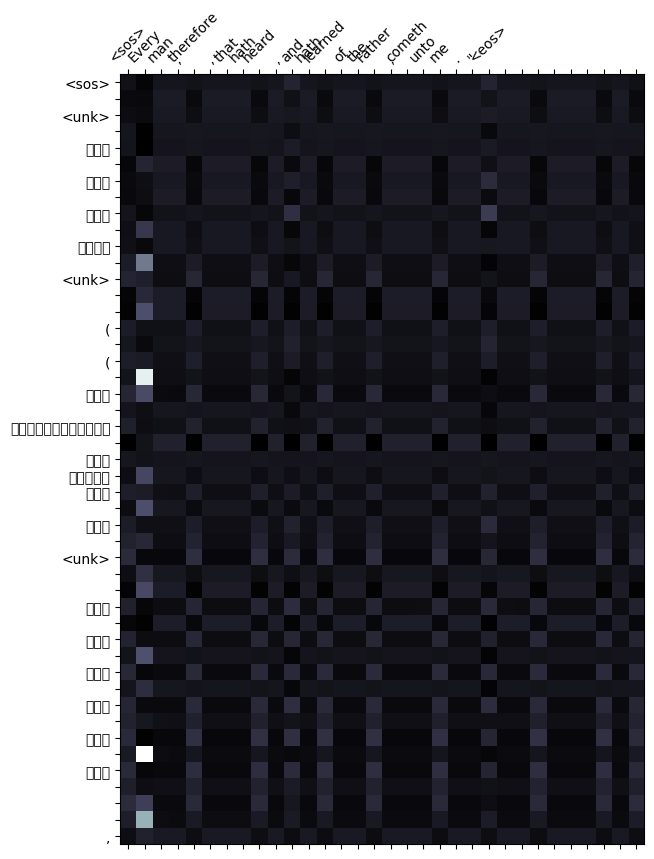

In [ ]:
display_attention(src_tokens, trg_tokens, attention)